In [2]:
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris["data"], iris["target"])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T
y_train = (y_train == 0).astype(np.int64)
y_test = (y_test == 0).astype(np.int64)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4, 112) (4, 38) (112,) (38,)


In [165]:
# new grad func
def calcLoss(actual, pred):
    return - actual / pred + (1 - actual) / (actual - pred)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def calcGrad(actual, pred):
    return pred - actual

# try building a general network
class NetLayer:

    def __init__(self, input_dim, output_dim, activation_func, keep_prob = 1):
        # note weight dimensions are reversed from typical nnet specs
        self.w = np.random.randn(input_dim, output_dim)
        self.b = np.random.randn(output_dim, 1)
        self.activation_func = activation_func
        # value for dropout - default 1 for no dropout
        self.keep_prob = keep_prob

    def forward(self, X, train = True):
        # record activations
        self.A_L_minus_one = X.copy()
        if train:
            dropout_mat = np.random.rand(X.shape[0], X.shape[1]) < self.keep_prob
            A = np.multiply(dropout_mat, X) / self.keep_prob
        else:
            A = X
        self.A_L = self.activation_func(np.dot(self.w.T, A) + self.b)
        # pass activation to next layer
        return self.A_L.copy()

    def backward(self, da, m):
        dz = da * self.A_L * (1 - self.A_L)
        da = np.dot(self.w, dz)
        dw = np.dot(dz, self.A_L_minus_one.T) / m
        db = np.sum(dz, axis = 1, keepdims= True) / m
        return da, dw, db

    def update_weights(self, new_weights, new_bias):

        self.w += new_weights
        self.b += new_bias

class NeuralNetwork:
    
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, train = True):
        for L in self.layers:
            X = L.forward(X, train = train)
        return X

    def train(self, X, y, epochs = 1, learning_rate = 0.01, batch_size = 150, lambd = 0):

        # record training errors
        errors = {}

        for i in range(epochs):
            # get a random batch sample
            if batch_size < X.shape[1]:
                samps = [np.random.randint(X.shape[1]) for i in range(batch_size)]
                y_actual = y[samps]
                A = X[:,samps].copy()
            else:
                A = X.copy()
                y_actual = y
            
            # forward pass
            A = self.forward(A)

            # calc the error
            da = calcGrad(y_actual, A)

            errors[i] = np.sum(da) 

            # back prop
            for j in range(len(self.layers) - 1, -1, -1):
                current_layer = self.layers[j]
                da, dw, db = current_layer.backward(da, batch_size)
                ### convert dimensions back using transpose because of our convention - (input_dim, output_dim)
                update_w = - learning_rate * dw.T 
                update_b = - learning_rate * db
                current_layer.update_weights(update_w, update_b)
        return errors

    def predict(self, X):
        # forward pass
        A = self.forward(X, train = False)
        return A



<AxesSubplot:>

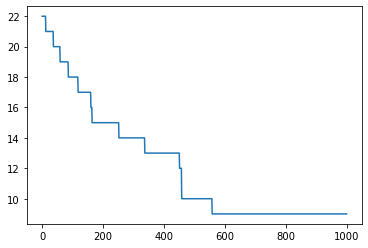

In [195]:
layer1 = NetLayer(4, 1, sigmoid)
layer2 = NetLayer(3, 3, sigmoid)
layer3 = NetLayer(3, 1, sigmoid, 0.3)

layers = [
    layer1,
    #layer2,
    # layer3
]

net = NeuralNetwork(layers)


results = net.train(X_train, y_train, batch_size = X_train.shape[1], epochs =1000, learning_rate=0.01)

# check that cost function is converging
pd.Series(results).plot()

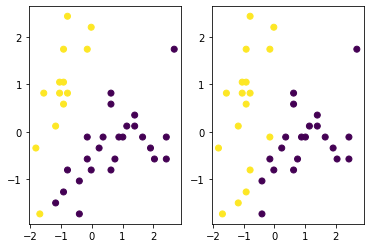

In [196]:
preds = np.round(net.predict(X_test))
fig, ax = plt.subplots(1,2)

# check how well our predictions match the truth
# note just training set - just checking that our model does work as we expect, not generalisability
ax[0].scatter(X_test[0,:], X_test[1,:], c = y_test)
ax[1].scatter(X_test[0,:], X_test[1,:], c = preds);

              precision    recall  f1-score   support

           0       1.00      0.84      0.91        25
           1       0.76      1.00      0.87        13

    accuracy                           0.89        38
   macro avg       0.88      0.92      0.89        38
weighted avg       0.92      0.89      0.90        38



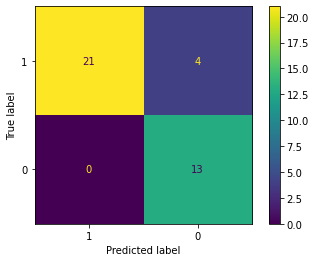

In [197]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, preds.reshape(38))
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(classification_report(y_test, preds.reshape(38)))

In [198]:
print(layer1.w, layer1.b)

[[-1.20102986]
 [ 0.74477675]
 [-0.24459625]
 [-0.2218641 ]] [[0.24376896]]


In [170]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state = 1, max_iter = 99999,fit_intercept = True, penalty = 'none')
log_reg.fit(X_train.T, y_train)
print(log_reg.coef_, log_reg.intercept_)


[[-2.15244839  5.28144014 -6.82656977 -6.89419122]] [-8.25011072]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        13

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



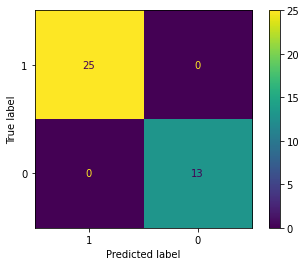

In [171]:

log_preds = log_reg.predict(X_test.T)

cm = confusion_matrix(y_test, log_preds)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(classification_report(y_test, log_preds))

In [193]:
log_reg.coef_[0][1:]

array([ 5.28144014, -6.82656977, -6.89419122])